**Disclaimer:** Scraping data is often considered illegal and unethical if done without proper permissions. This project and its content are intended **solely for educational purposes** to demonstrate technical concepts.

In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Scrape data from the website
base_url = "https://seismonepal.gov.np/earthquakes/index"

max_pages = 62  # Update as needed
# max_pages = 5  # to test

# Function to scrape data from a single page
def scrape_page(page_url):
    response = requests.get(page_url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Locate the table
    table = soup.find('table', {'class': 'table table-striped table-bordered'})
    rows = table.find('tbody').find_all('tr')

    data = []
    for row in rows:
        cols = row.find_all('td')
        cols = [col.text.strip() for col in cols]
        if cols:  # Check for non-empty rows
            data.append({
                'Date': cols[1],
                'Time': cols[2],
                'Latitude': str(cols[3]),
                'Longitude': str(cols[4]),
                'Magnitude': cols[5],
                'Epicenter': cols[6]
            })
    return data

# Main function to scrape multiple pages
def scrape_all_pages(base_url, max_pages):
    all_data = []
    for page in range(1, max_pages + 1):
        url = f"{base_url}?page={page}"
        page_data = scrape_page(url)
        all_data.extend(page_data)
        # print(f"Scraped page {page}") #this step can take some time, to see the progress of scraping data, uncomment this line
    return all_data

data = scrape_all_pages(base_url, max_pages)
# print(data)
print('data scraped successfully')

data scraped successfully


In [4]:
# Function to clean date field
def clean_date(date_str):
    # Extract the A.D. date part
    if 'A.D.:' in date_str:
        return date_str.split('A.D.:')[1].strip()
    return None

# Function to clean time field
def clean_time(time_str):
    # Extract the Local time part
    if 'Local:' in time_str:
        return time_str.split('Local:')[1].split('UTC:')[0].strip()
    return None

# Function to clean numeric fields
def clean_numeric(value):
    try:
        return float(value)
    except ValueError:
        return None

# Clean and process the data
cleaned_data = []
for entry in data:
    cleaned_entry = {
        'Date': clean_date(entry['Date']),
        'Time': clean_time(entry['Time']),
        'Latitude': clean_numeric(entry['Latitude']),
        'Longitude': clean_numeric(entry['Longitude']),
        'Magnitude': clean_numeric(entry['Magnitude']),
        'Epicenter': entry['Epicenter']
    }
    cleaned_data.append(cleaned_entry)

# Convert to DataFrame
df = pd.DataFrame(cleaned_data)

#remove null value from latitude and longitude
df = df.dropna(subset=['Latitude', 'Longitude'], how='any')

# Ensure the Latitude and Longitude columns are treated as strings before replacing
df.loc[:, 'Latitude'] = df['Latitude'].astype(str).str.replace(':', '.').astype(float)
df.loc[:, 'Longitude'] = df['Longitude'].astype(str).str.replace(':', '.').astype(float)

# Convert 'Date' to date-only
df['Date'] = pd.to_datetime(df['Date']).dt.date

# Combine 'Date' and 'Time' when needed
df['Datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Time'].astype(str))

# Save to CSV
df.to_csv('earthquake_data_nepal.csv', index=False)
print("Data saved to earthquake_data_nepal.csv")

Data saved to earthquake_data_nepal.csv


In [6]:
import pandas as pd
# Load data
df = pd.read_csv('earthquake_data_nepal.csv')

In [7]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1234 entries, 0 to 1233
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1234 non-null   object 
 1   Time       1234 non-null   object 
 2   Latitude   1234 non-null   float64
 3   Longitude  1234 non-null   float64
 4   Magnitude  1234 non-null   float64
 5   Epicenter  1234 non-null   object 
 6   Datetime   1234 non-null   object 
dtypes: float64(3), object(4)
memory usage: 67.6+ KB
None


In [6]:
# Display DataFrame
print(df)

            Date   Time  Latitude  Longitude  Magnitude        Epicenter  \
0     2025-01-07  06:50     28.31      87.37        7.0  Dinggye, China*   
1     2025-01-03  08:03     29.57      82.19        4.4             Mugu   
2     2025-01-03  08:29     28.54      84.13        4.1           Manang   
3     2025-01-02  13:02     27.77      85.57        4.8    Sindhupalchok   
4     2024-12-31  07:54     29.45      80.86        4.6          Baitadi   
...          ...    ...       ...        ...        ...              ...   
1232  1994-06-25  14:17     27.82      86.19        5.1          Dolakha   
1233  1994-05-25  19:10     29.80      82.41        4.5             Mugu   
1234  1994-05-25  12:00     29.81      81.77        4.0           Bajura   
1235  1994-05-03  00:30     28.52      83.03        4.4          Baglung   
1236  1994-03-08  07:50     29.33      81.83        4.0          Kalikot   

                Datetime  
0    2025-01-07 06:50:00  
1    2025-01-03 08:03:00  
2    2

In [8]:
print(df.describe())

          Latitude    Longitude    Magnitude
count  1234.000000  1234.000000  1234.000000
mean     28.285024    84.664668     4.371556
std       1.892666     2.140369     0.502864
min      23.710000    69.850000     4.000000
25%      27.720000    82.550000     4.000000
50%      27.940000    85.340000     4.200000
75%      28.617500    86.100000     4.500000
max      87.840000    89.880000     7.600000


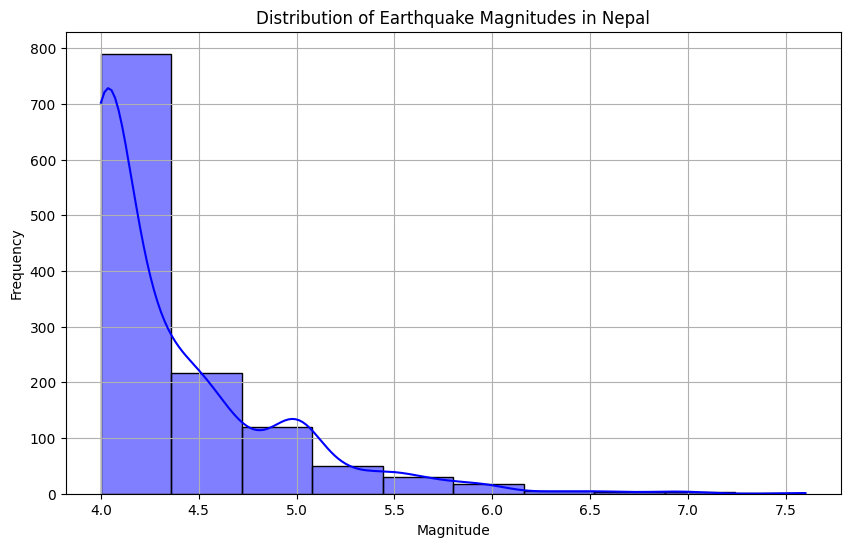

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization: Histogram of Magnitudes
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
sns.histplot(df['Magnitude'], bins=10, kde=True, color='blue')
plt.title('Distribution of Earthquake Magnitudes in Nepal')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

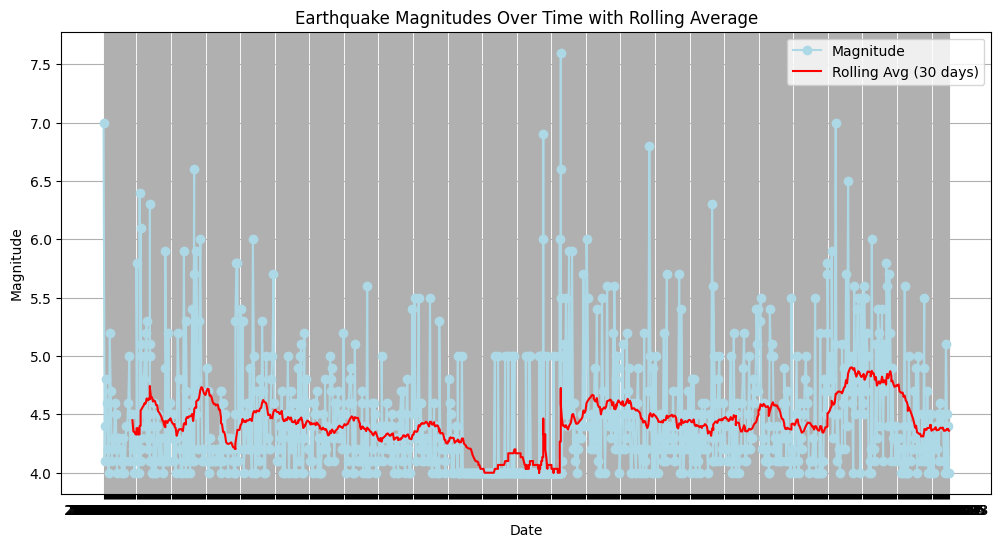

In [16]:
# Calculate Time Series Analysis with Rolling Averages
df['Rolling_Magnitude_Avg'] = df['Magnitude'].rolling(window=30).mean()  # Adjust window as needed

# Plot time series with rolling average
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Magnitude'], marker='o', linestyle='-', color='lightblue', label='Magnitude')
plt.plot(df['Date'], df['Rolling_Magnitude_Avg'], color='red', label='Rolling Avg (30 days)')
plt.title('Earthquake Magnitudes Over Time with Rolling Average')
plt.xlabel('Date')
plt.ylabel('Magnitude')
plt.grid(True)
plt.legend()
plt.show()

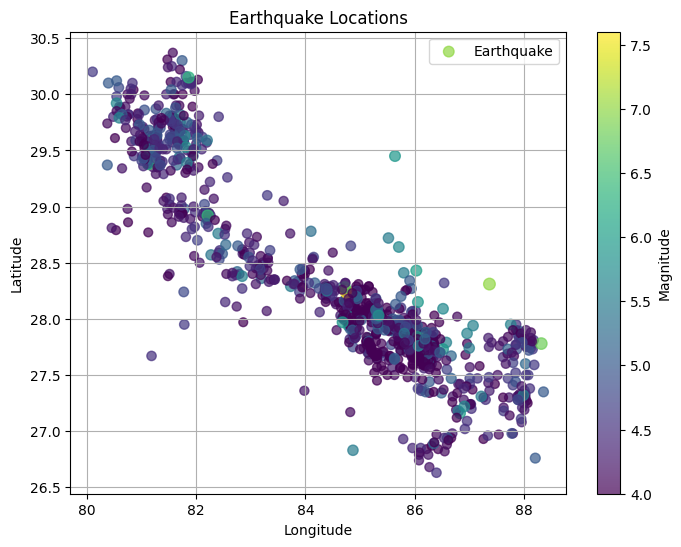

In [15]:
# Visualization: Scatter Plot of Earthquake Locations

# Define the bounding box for Nepal (approximate values)
min_latitude = 26.3
max_latitude = 30.5
min_longitude = 80.0
max_longitude = 88.5

# Filter the DataFrame
filtered_df = df[
    (df['Latitude'] >= min_latitude) & (df['Latitude'] <= max_latitude) &
    (df['Longitude'] >= min_longitude) & (df['Longitude'] <= max_longitude)
]
plt.figure(figsize=(8, 6))

cmap = 'viridis' # Using built-in colormap

plt.scatter(filtered_df['Longitude'], filtered_df['Latitude'],
            s=filtered_df['Magnitude']*10, alpha=0.7,
            c=filtered_df['Magnitude'], cmap=cmap, label='Earthquake')
plt.colorbar(label='Magnitude')
plt.title('Earthquake Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()

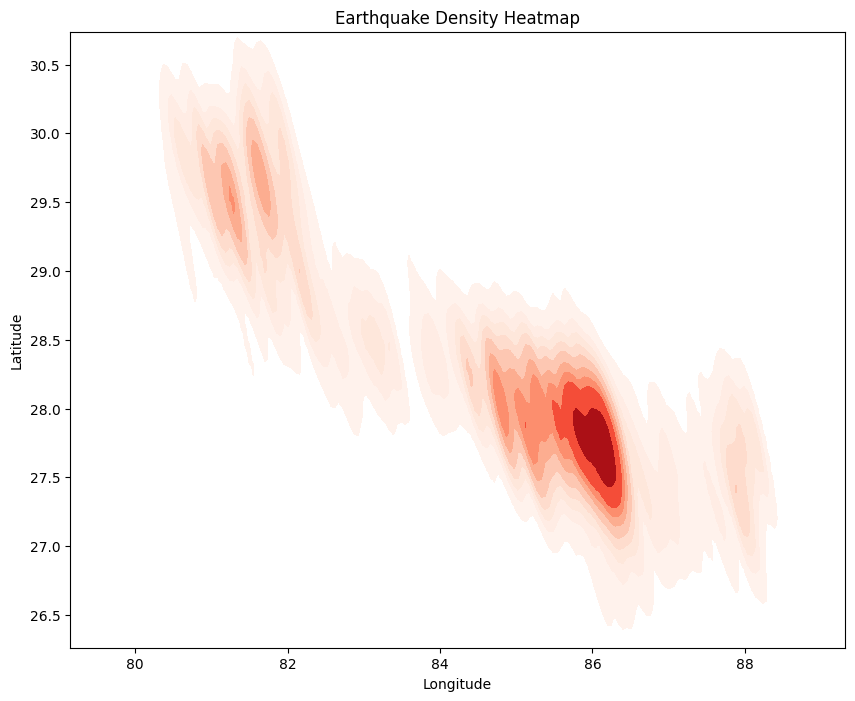

In [12]:
# Create a heatmap
plt.figure(figsize=(10, 8))
sns.kdeplot(x=filtered_df['Longitude'], y=filtered_df['Latitude'], cmap="Reds", fill=True, bw_adjust=.5)
plt.title('Earthquake Density Heatmap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [4]:
import folium
from IPython.display import display

# Create a map centered on Nepal
map_nepal = folium.Map(location=[28.3949, 84.1240], zoom_start=7)

# Add markers for each earthquake
for _, row in df.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"Date: {row['Date']}, Time: {row['Time']}, Magnitude: {row['Magnitude']}, Epicenter: {row['Epicenter']}",
        icon=folium.Icon(color='red' if row['Magnitude'] >= 5 else 'orange')
    ).add_to(map_nepal)

# Save map to an HTML file
map_nepal.save('earthquake_map_nepal.html')
print("Map saved to earthquake_map_nepal.html")

# Display the map directly:
display(map_nepal)

Map saved to earthquake_map_nepal.html


In [5]:
# Code for Heatmap on Nepal Map
from folium.plugins import HeatMap

# Initialize a map centered around Nepal
nepal_map = folium.Map(location=[28.3949, 84.1240], zoom_start=7)

# Prepare data for HeatMap
heat_data = df[['Latitude', 'Longitude', 'Magnitude']].values.tolist()

# Add HeatMap layer
HeatMap(heat_data, radius=15).add_to(nepal_map)

# Save the map as an HTML file
nepal_map.save("nepal_earthquake_heatmap.html")

# Display the map (if running in a Jupyter Notebook or interactive environment)
nepal_map